In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sentiment-classification/train.csv
/kaggle/input/sentiment-classification/CNN1_model.h5
/kaggle/input/sentiment-classification/CNN2_model.h5
/kaggle/input/sentiment-classification/test.csv


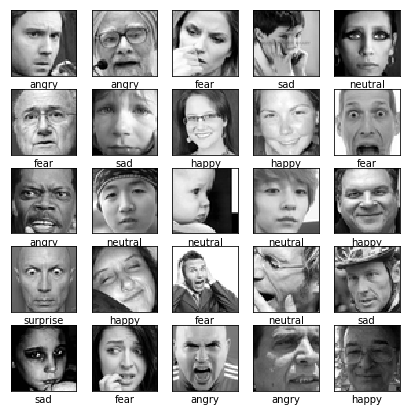

In [2]:
# import data
master_train = pd.read_csv('../input/sentiment-classification/train.csv')
master_test = pd.read_csv('../input/sentiment-classification/test.csv')

# define training data dimension
m = master_train.shape[0]
n_w = 48
n_h = 48
n_c = 1

# store training data in arrays of correct dimensions
X = np.zeros((m, n_w, n_h, n_c), dtype=int)
y = np.zeros((m), dtype=int)
for i in range(m):
    X[i] = np.fromstring(master_train['feature'][i], dtype=int, sep=' ').reshape(n_w, n_h, n_c)
    y[i] = int(master_train['label'][i])
    
 # store testing data in arrays of correct dimensions   
X_test = np.zeros((master_test.shape[0], n_w, n_h, n_c), dtype = int)
for i in range(master_test.shape[0]):
    X_test[i] = np.fromstring(master_test['feature'][i], dtype=int, sep=' ').reshape(n_w, n_h, n_c)
    
import matplotlib.pyplot as plt
    
# create a list of sentiment labels
sentiment_label = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
# plot and label first 25 images
plt.figure(figsize= (7, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i].squeeze(), cmap=plt.cm.gray)
    plt.xlabel(sentiment_label[y[i]])
plt.show()

**Now that I have visualized the images and got a better idea of what the dataset looks like, I need to split the data first before developing a model.
The original training set is split into training, development and validation(holdout) sets following a ratio of 8: 1: 1, where training and devlepment set are used to build and tune the model, and validation set is kept unseen from the model until the model is ready to be validated. The motivation behind this is to prevent overfitting of the data to the validation set during model tunning**

In [3]:
# import a tool for splitting the data
from sklearn.model_selection import train_test_split
# normalize the original train data and test data to values between 0 and 1 
X = X/255.0
X_test = X_test/255.0
# use training_test_split twice to achieve the mentioned ratio. 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size = 0.8, random_state= 40)
X_dev, X_val, y_dev, y_val = train_test_split(X_temp, y_temp, train_size = 0.5, random_state = 40)
# print the size of each set to ensure it is correct
print('size of training set: ', X_train.shape)
print('size of development set: ', X_dev.shape)
print('size of validation set: ', X_val.shape)

size of training set:  (15999, 48, 48, 1)
size of development set:  (2000, 48, 48, 1)
size of validation set:  (2000, 48, 48, 1)


In [4]:
# import keras functions for model building
from keras import losses
from keras import activations

from keras.regularizers import l2
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model

Using TensorFlow backend.


**I first start with a baseline model by following the official Keras CNN classification tutorial. A baseline model normally meets the requirement of random guessing, which yields a minimum accuracy of 1/7 for classification of 7 different emotions. It can be used to test against the perfromance future models.**

**In this case, the baseline model is a 5 layer CNN. The first 3 layers are 2D convolutional layers followed by max pooling, and the last 2 layers are fully connected layers, where the output layer uses a softmax activation function with 7 nodes.**

In [5]:
# define a function for baseline model. 
def bl_model(input_shape):
    X_input = Input(input_shape)
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv0')(X_input)   
    X = BatchNormalization(name = 'bn0')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name = 'max_pool0')(X)
    
    X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(name = 'bn1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name = 'max_pool1')(X)
    
    X = Conv2D(128, (3, 3), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(name = 'bn2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name = 'max_pool2')(X)
    
    X = Flatten()(X)
    X = Dense(64, name = 'fc0')(X)
    X = BatchNormalization(name = 'bn3')(X)
    X = Activation('relu')(X)
    X = Dense(7, activation = 'softmax', name = 'fc1')(X)
    
    model = Model(inputs = X_input, outputs = X, name = 'Baseline_Model')
    
    return model
# call the baseline model function and define the shape of input tensor
baseline_model = bl_model((48, 48, 1))
# build model with Adam optimizer, categorical crossentropy and accuracy as the evaluation metrics
baseline_model.compile(optimizer= 'adam', loss = losses.sparse_categorical_crossentropy, metrics = ['accuracy'])
# fit the model with training data, and validate with development data.
# the model is ran for 10 epochs
history_bl = baseline_model.fit(X_train, y_train, epochs=10, validation_data=(X_dev, y_dev))

Train on 15999 samples, validate on 2000 samples
Epoch 1/10
15999/15999 [==============================] - 10s 646us/step - loss: 1.5503 - accuracy: 0.4013 - val_loss: 1.5467 - val_accuracy: 0.4225
Epoch 2/10
15999/15999 [==============================] - 5s 335us/step - loss: 1.2803 - accuracy: 0.5112 - val_loss: 1.4310 - val_accuracy: 0.4505
Epoch 3/10
15999/15999 [==============================] - 5s 328us/step - loss: 1.1434 - accuracy: 0.5761 - val_loss: 1.3843 - val_accuracy: 0.4740
Epoch 4/10
15999/15999 [==============================] - 5s 335us/step - loss: 1.0117 - accuracy: 0.6220 - val_loss: 1.5256 - val_accuracy: 0.4820
Epoch 5/10
15999/15999 [==============================] - 6s 360us/step - loss: 0.8776 - accuracy: 0.6759 - val_loss: 1.3452 - val_accuracy: 0.5205
Epoch 6/10
15999/15999 [==============================] - 6s 374us/step - loss: 0.7326 - accuracy: 0.7352 - val_loss: 1.4713 - val_accuracy: 0.5265
Epoch 7/10
15999/15999 [==============================] - 6s 3

**After a model is built and fit with training data, it is important to visualize its performance. Specifically, the fitting graph of loss(error) or accuracy vs # of epochs can show whether there is overfitting or underfitting**

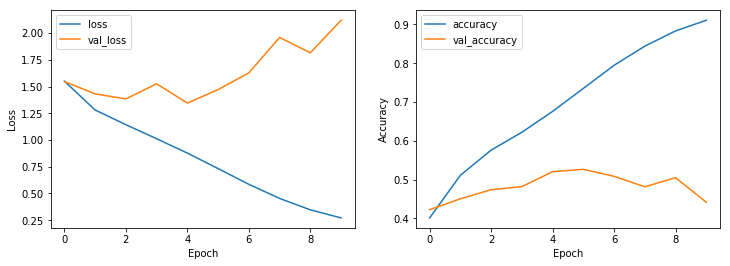

In [6]:
# plot Loss vs # of epochs and Accuracy vs # of epochs
plt.figure(figsize= (12, 4))
# plot first subfigure
plt.subplot(121)
plt.plot(history_bl.history['loss'], label='loss')
plt.plot(history_bl.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
# plot second subfigure
plt.subplot(122)
plt.plot(history_bl.history['accuracy'], label='accuracy')
plt.plot(history_bl.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

**The fitting graph shows that there is significant overfitting: the accuracy of training set is above 90% after 10 epochs, the accuracy of the development data is only around 50%. Also, In case of classification, loss might be a more insightful indicator of the model performance. In ths case, loss of development set started increasing after 4 epochs**

**For the actual model, I did some research on the CNN architecture for emtion detection. The paper [_Training Deep Neworks for Facial Expression Recognition with Crowd-Sourced Label Distribution_](https://arxiv.org/pdf/1608.01041v2.pdf) by researchers at Microsoft Research suggested a VGG-13 network. This architecture has 13 layers, which consists of 10 convolutional layers and 3 fully connected layers. This paper also suggeested using dropout regularizer to reduce overfitting. So I have implemented this architecture to test its performance on our data. In addition, I am using batch normalization to normalize activation units of each layer.**

In [7]:
# define a function for the first CNN
def CNN1_model(input_shape):
    X_input = Input(input_shape)
    # add 2 convolutional layer, each has 64 of 3 x 3 filters, followed by BatchNorm and a relu activation function
    X = Conv2D(64, (3, 3), name = 'conv0_0')(X_input)
    X = BatchNormalization(name = 'bn0_0')(X)
    X = Activation('relu')(X)
    X = Conv2D(64, (3, 3), padding = 'same', name = 'conv0_1')(X)
    X = BatchNormalization(name = 'bn0_1')(X)
    X = Activation('relu')(X)
    # add a maxpooling layer and a dropout layer with a dropout rate of 25%
    X = MaxPooling2D((2, 2), name = 'max_pool0')(X)
    X = Dropout(0.25)(X)
    
    # add 2 convolutional layer, each has 128 of 3 x 3 filters, followed by BatchNorm and a relu activation function
    X = Conv2D(128, (3, 3), padding = 'same', name = 'conv1_0')(X)
    X = BatchNormalization(name = 'bn1_0')(X)
    X = Activation('relu')(X)
    X = Conv2D(128, (3, 3), padding = 'same', name = 'conv1_1')(X)
    X = BatchNormalization(name = 'bn1_1')(X)
    X = Activation('relu')(X)
    # add a maxpooling layer and a dropout layer with a dropout rate of 25%
    X = MaxPooling2D((2, 2), name = 'max_pool1')(X)
    X = Dropout(0.25)(X)
    
    # add 3 convolutional layer, each has 256 of 3 x 3 filters, followed by BatchNorm and a relu activation function
    X = Conv2D(256, (3, 3), padding = 'same', name = 'conv2_0')(X)
    X = BatchNormalization(name = 'bn2_0')(X)
    X = Activation('relu')(X)
    X = Conv2D(256, (3, 3), padding = 'same', name = 'conv2_1')(X)
    X = BatchNormalization(name = 'bn2_1')(X)
    X = Activation('relu')(X)
    X = Conv2D(256, (3, 3), padding = 'same', name = 'conv2_2')(X)
    X = BatchNormalization(name = 'bn2_2')(X)
    X = Activation('relu')(X)
    # add a maxpooling layer and a dropout layer with a dropout rate of 25%
    X = MaxPooling2D((2, 2), name = 'max_pool2')(X)
    X = Dropout(0.25)(X)
    
    # add 3 convolutional layer, each has 256 of 3 x 3 filters, followed by BatchNorm and a relu activation function    
    X = Conv2D(256, (3, 3), padding = 'same', name = 'conv3_0')(X)
    X = BatchNormalization(name = 'bn3_0')(X)
    X = Activation('relu')(X)
    X = Conv2D(256, (3, 3), padding = 'same', name = 'conv3_1')(X)
    X = BatchNormalization(name = 'bn3_1')(X)
    X = Activation('relu')(X)
    X = Conv2D(256, (3, 3), padding = 'same', name = 'conv3_2')(X)
    X = BatchNormalization(name = 'bn3_2')(X)
    X = Activation('relu')(X)
    # add a maxpooling layer and a dropout layer with a dropout rate of 25%
    X = MaxPooling2D((2, 2), name = 'max_pool3')(X)
    X = Dropout(0.25)(X)
    
    # flatten the output from the last convolutional layer
    X = Flatten()(X)
    
    # add 2 fully connected layers, each has 1024 nodes, followed by BatchNorm and a relu activation funciton
    X = Dense(1024, name = 'fc0')(X)
    X = BatchNormalization(name = 'bn4_0')(X)
    X = Activation('relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(1024, name = 'fc1')(X)
    X = BatchNormalization(name = 'bn4_1')(X)
    X = Activation('relu')(X)
    X = Dropout(0.5)(X)
    
    # add an output layer with 7 nodes and a softmax activation funciton
    X = Dense(7, activation = 'softmax', name = 'fc2')(X)
    
    model = Model(inputs = X_input, outputs = X, name = 'CNN1')    
    return model
# call the CNN model function and define the size of input tensor
CNN1_model = CNN1_model((48, 48, 1))
# build and fit the model with Adam optimizer
# the model is ran for 50 epochs
CNN1_model.compile(optimizer= 'adam', loss = losses.sparse_categorical_crossentropy, metrics = ['accuracy'])
history_CNN1 = CNN1_model.fit(X_train, y_train, epochs=50, batch_size= 32, validation_data=(X_dev, y_dev))

Train on 15999 samples, validate on 2000 samples
Epoch 1/50
15999/15999 [==============================] - 21s 1ms/step - loss: 2.1134 - accuracy: 0.2194 - val_loss: 4.8142 - val_accuracy: 0.2065
Epoch 2/50
15999/15999 [==============================] - 18s 1ms/step - loss: 1.9560 - accuracy: 0.2441 - val_loss: 1.8576 - val_accuracy: 0.2820
Epoch 3/50
15999/15999 [==============================] - 17s 1ms/step - loss: 1.8206 - accuracy: 0.3088 - val_loss: 2.0992 - val_accuracy: 0.2320
Epoch 4/50
15999/15999 [==============================] - 17s 1ms/step - loss: 1.6705 - accuracy: 0.3813 - val_loss: 1.7275 - val_accuracy: 0.3350
Epoch 5/50
15999/15999 [==============================] - 18s 1ms/step - loss: 1.5435 - accuracy: 0.4244 - val_loss: 1.4520 - val_accuracy: 0.4320
Epoch 6/50
15999/15999 [==============================] - 17s 1ms/step - loss: 1.4510 - accuracy: 0.4592 - val_loss: 1.4495 - val_accuracy: 0.4430
Epoch 7/50
15999/15999 [==============================] - 17s 1ms/ste

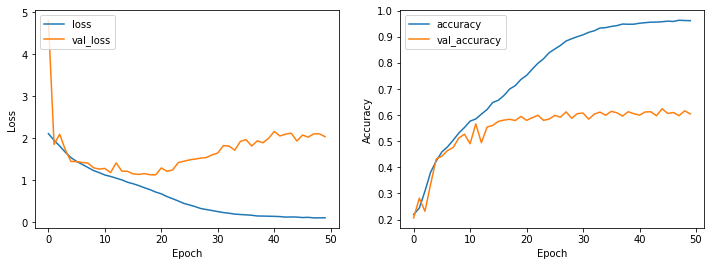

In [8]:
# plot Loss vs # of epochs and Accuracy vs # of epochs
plt.figure(figsize= (12, 4))
plt.subplot(121)
plt.plot(history_CNN1.history['loss'], label='loss')
plt.plot(history_CNN1.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.subplot(122)
plt.plot(history_CNN1.history['accuracy'], label='accuracy')
plt.plot(history_CNN1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

**The VGG-13 model definitely does better than the baseline model. Its accuracy reached 60%, and the loss was as low as 1.13 at minimum. On top of that, the model does not seem to have an underfitting issue as its accuracy reached over 95% on the training set. However, there is still some overfitting despite the employment of dropout regularizer. To help this, I am increasing the dropout rate of the convolutional layers as well as utilizing a L2 regularizer on the first convolutional layer.**

In [49]:
# define a function for the updated VGG-13 model.
def CNN2_model(input_shape):
    X_input = Input(input_shape)
    # add a L2 regularizer to the first convolutional layer, with a regularization parameter of 0.001
    X = Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=l2(0.001), name = 'conv0_0')(X_input)
    X = BatchNormalization(name = 'bn0_0')(X)
    X = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', name = 'conv0_1')(X)
    X = BatchNormalization(name = 'bn0_1')(X)
    X = MaxPooling2D((2, 2), name = 'max_pool0')(X)
    # the dropout rate is increased from 25% to 50%
    X = Dropout(0.5)(X)
    
    X = Conv2D(128, (3, 3), padding = 'same', activation = 'relu', name = 'conv1_0')(X)
    X = BatchNormalization(name = 'bn1_0')(X)
    X = Conv2D(128, (3, 3), padding = 'same', activation = 'relu', name = 'conv1_1')(X)
    X = BatchNormalization(name = 'bn1_1')(X)
    X = MaxPooling2D((2, 2), name = 'max_pool1')(X)
    # the dropout rate is increased from 25% to 50%
    X = Dropout(0.5)(X)
    
    X = Conv2D(256, (3, 3), padding = 'same', activation = 'relu', name = 'conv2_0')(X)
    X = BatchNormalization(name = 'bn2_0')(X)
    X = Conv2D(256, (3, 3), padding = 'same', activation = 'relu', name = 'conv2_1')(X)
    X = BatchNormalization(name = 'bn2_1')(X)
    X = Conv2D(256, (3, 3), padding = 'same', activation = 'relu', name = 'conv2_2')(X)
    X = BatchNormalization(name = 'bn2_2')(X)
    X = MaxPooling2D((2, 2), name = 'max_pool2')(X)
    # the dropout rate is increased from 25% to 50%
    X = Dropout(0.5)(X)
    
    X = Conv2D(256, (3, 3), padding = 'same', activation = 'relu', name = 'conv3_0')(X)
    X = BatchNormalization(name = 'bn3_0')(X)
    X = Conv2D(256, (3, 3), padding = 'same', activation = 'relu', name = 'conv3_1')(X)
    X = BatchNormalization(name = 'bn3_1')(X)
    X = Conv2D(256, (3, 3), padding = 'same', activation = 'relu', name = 'conv3_2')(X)
    X = BatchNormalization(name = 'bn3_2')(X)
    X = MaxPooling2D((2, 2), name = 'max_pool3')(X)
    # the dropout rate is increased from 25% to 50%
    X = Dropout(0.5)(X)
       
    X = Flatten()(X)
    
    X = Dense(1024, activation = 'relu', name = 'fc0')(X)
    X = BatchNormalization(name = 'bn4_0')(X)
    X = Dropout(0.5)(X)
    X = Dense(1024, activation = 'relu', name = 'fc1')(X)
    X = BatchNormalization(name = 'bn4_1')(X)
    X = Dropout(0.5)(X)
    
    X = Dense(7, activation = 'softmax', name = 'fc2')(X)
    
    model = Model(inputs = X_input, outputs = X, name = 'CNN2')
    
    return model
# call the CNN model function and define the size of input tensor
CNN2_model = CNN2_model((48, 48, 1))
# print the model summary
CNN2_model.summary()

Model: "CNN2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 48, 48, 1)         0         
_________________________________________________________________
conv0_0 (Conv2D)             (None, 46, 46, 64)        640       
_________________________________________________________________
bn0_0 (BatchNormalization)   (None, 46, 46, 64)        256       
_________________________________________________________________
conv0_1 (Conv2D)             (None, 46, 46, 64)        36928     
_________________________________________________________________
bn0_1 (BatchNormalization)   (None, 46, 46, 64)        256       
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 23, 23, 64)        0      

**In addtional to the L2 regularizer, I also notice that in the previous VGG-13 model, the accuracy and loss tends to fluctuate at some points, therefore, I am using a learning rate reducer. On top of that, an early stoper is also used to interrupt the training if loss on development set lingers for an excessive number of epochs.**

In [50]:
# define a learning rate reducer, which reduces the learning rate by 10% if loss on development 
# set shows no improvement for 2 epochs
LR_callbacks = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.9, patience = 2)
# define an early stopper, which terminates training if loss on development set shows no 
# improvement for 2 epochs
ES_callbacks = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 6, mode='auto')
# build and fit the model with Adam optimizer
# the model is ran for 50 epochs with the callbacks defined previously
CNN2_model.compile(optimizer= 'adam', loss = losses.sparse_categorical_crossentropy, metrics = ['accuracy'])
history_CNN2 = CNN2_model.fit(X_train, y_train, epochs=50, batch_size= 32, validation_data=(X_dev, y_dev), callbacks = [LR_callbacks, ES_callbacks])

Train on 15999 samples, validate on 2000 samples
Epoch 1/50
15999/15999 [==============================] - 21s 1ms/step - loss: 2.4382 - accuracy: 0.1965 - val_loss: 2.1265 - val_accuracy: 0.2080
Epoch 2/50
15999/15999 [==============================] - 17s 1ms/step - loss: 2.0133 - accuracy: 0.2220 - val_loss: 1.8310 - val_accuracy: 0.2455
Epoch 3/50
15999/15999 [==============================] - 17s 1ms/step - loss: 1.9206 - accuracy: 0.2533 - val_loss: 1.6892 - val_accuracy: 0.3370
Epoch 4/50
15999/15999 [==============================] - 17s 1ms/step - loss: 1.7331 - accuracy: 0.3428 - val_loss: 1.7026 - val_accuracy: 0.3645
Epoch 5/50
15999/15999 [==============================] - 17s 1ms/step - loss: 1.5781 - accuracy: 0.3950 - val_loss: 1.5021 - val_accuracy: 0.4585
Epoch 6/50
15999/15999 [==============================] - 17s 1ms/step - loss: 1.4404 - accuracy: 0.4455 - val_loss: 1.3685 - val_accuracy: 0.5100
Epoch 7/50
15999/15999 [==============================] - 17s 1ms/ste

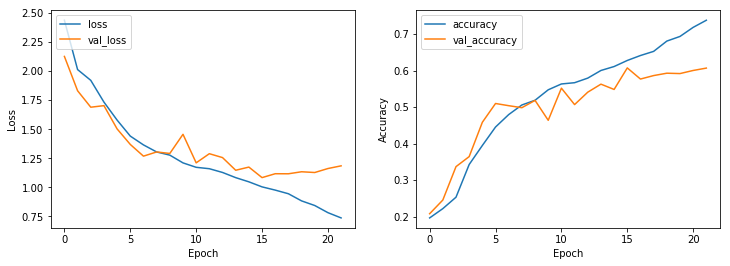

In [51]:
# plot Loss vs # of epochs and Accuracy vs # of epochs
plt.figure(figsize= (12, 4))
plt.subplot(121)
plt.plot(history_CNN2.history['loss'], label='loss')
plt.plot(history_CNN2.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.subplot(122)
plt.plot(history_CNN2.history['accuracy'], label='accuracy')
plt.plot(history_CNN2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [56]:
# # save model and its parameter weights
# CNN1_model.save('CNN1_model.h5')
# CNN2_model.save('CNN2_model.h5')

**The updated VGG-13 model stopped training after just 22 epochs. This resulted from the integrated early stopper, which effectively kept the loss at below 1.2 while keeping the accuracy at over 60%. As I mentioned earlier, for classification problem with highly skewed dataset, a lower loss is a better indicator of generalization than a higher accuracy. Now that I am satisfied with the model performance, its performance will be tested against validation(holdout) set, along with the original VGG-13 model for comparison:**

In [13]:
# from keras.models import load_model
# CNN1_model = load_model('../input/sentiment-classification/CNN1_model.h5')
# CNN2_model = load_model('../input/sentiment-classification/CNN2_model.h5')

In [52]:
# import metrics library
from sklearn.metrics import accuracy_score, classification_report
# compute and print the accuracy of labels predicted by the original VGG-13 model
y_val_CNN1 = np.argmax(CNN1_model.predict(X_val), axis = 1)
print('Accuracy of VGG-13 without tunning: ', accuracy_score(y_val, y_val_CNN1))
# compute and print the accuracy of labels predicted by the updated VGG-13 model
y_val_CNN2 = np.argmax(CNN2_model.predict(X_val), axis = 1)
print('Accuracy of VGG-13 with some tunning: ', accuracy_score(y_val, y_val_CNN2))

Accuracy of VGG-13 without tunning:  0.5865
Accuracy of VGG-13 with some tunning:  0.6075


**As shown, the accruacy is improved by 2% after some tunning. I can also visualize this by plotting teh predicted and true labels on the actual images:**

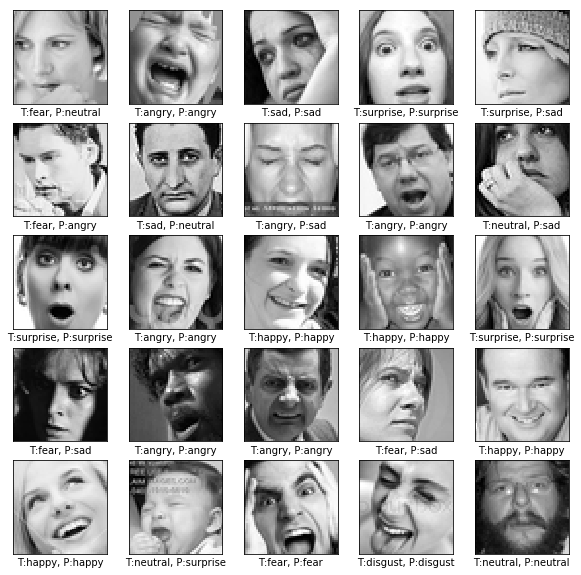

In [53]:
# plot the 25 images with theirs actual and predicted labels
plt.figure(figsize= (10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_val[i+100].squeeze(), cmap=plt.cm.gray)
    # label starts with true label, followed by predicted label
    plt.xlabel('T:' + sentiment_label[y_val[i+100]] + ', P:' + sentiment_label[y_val_CNN2[i+100]])
plt.show()

**The above figure shows that the model predicts 18 out of 25 emotions correctly. This performance can be better assessed by plotting a confusion matrix, which shows what the model emotions are the model 'good' or 'bad' at predicting.**

In [16]:
# import libraries for producing and visualizing confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

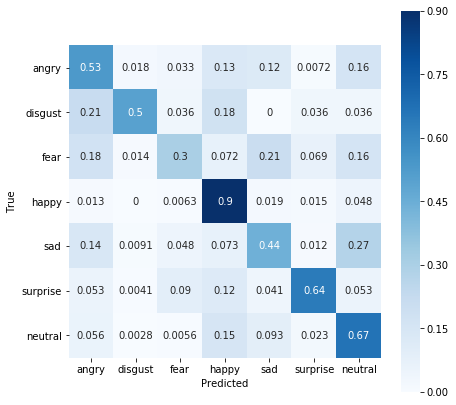

In [54]:
# normalize confusion matrix array by dividing it by the sum across True labels
confu_matrix = confusion_matrix(y_val, y_val_CNN2) / confusion_matrix(y_val, y_val_CNN2).sum(axis = 1)[:, None]
# plot confusion matrix
plt.figure(figsize = (7, 7))
sns.heatmap(confu_matrix, cmap='Blues', square = True, annot= True)
# use labels as ticks, set rotateion of y ticks to 0 to display it horizontally
plt.xticks(np.arange(7)+0.5, sentiment_label)
plt.yticks(np.arange(7)+0.5, sentiment_label, rotation = 0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**The confusion matrix shows that the positive (happy and surprise) and neural emotions have relatively higher accuracy than negative emotions (angry, disgust, fear and sad). Among these, 'happy' has the highest accuracy, this is probably due to the distinctive facial expression produced by a happy emotion. On the opposite, 'angry' and 'sad' are easily misclassified as 'neutral'. This analysis can be furthered by looking at the its classification report.**

In [55]:
# print classification report
print(classification_report(y_val, y_val_CNN2, target_names = sentiment_label))

              precision    recall  f1-score   support

       angry       0.51      0.53      0.52       276
     disgust       0.50      0.50      0.50        28
        fear       0.62      0.30      0.41       291
       happy       0.72      0.90      0.80       476
         sad       0.50      0.44      0.47       331
    surprise       0.79      0.64      0.71       244
     neutral       0.52      0.67      0.58       354

    accuracy                           0.61      2000
   macro avg       0.59      0.57      0.57      2000
weighted avg       0.61      0.61      0.59      2000



**Precision describes the ratio of TP over FP + TP, where as recall describes the ratio of TP over TP + FN. Typically for classfication problems, there would be a tradeoff between precision and recall. Depending on the application, one might choose to optimize one over the other. For instance, for disease diagnostic tool, it is crucial maximize recall because it might be better to misdiagnose a healthy patient than not detecting the problem in an ill patient. Alternatively, a good matrics would then be f1-score, which is 2 times the product of precision and recall, divided by the sum of the two. Typically, the higher the f1 score, the better the model is at classifying that class. In this case, the low performance on 'disgust' is likely due to its small training size (only 28 samples in validation(holdout) set).**